In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_targets_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 1576)
(631390, 1)
validation
(74368, 1576)
(74368, 1)
test
(85358, 1576)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2304001 (8.79 MB)


Trainable params: 2304001 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:41 - loss: 0.1542 - STD: 1.4203e-04 - MAE: 0.3798

 3/64 [>.............................] - ETA: 2s - loss: 0.0658 - STD: 3.3612e-04 - MAE: 0.2006  

 5/64 [=>............................] - ETA: 2s - loss: 0.0506 - STD: 2.6785e-04 - MAE: 0.1697

 7/64 [==>...........................] - ETA: 2s - loss: 0.0465 - STD: 2.0768e-04 - MAE: 0.1655

 9/64 [===>..........................] - ETA: 2s - loss: 0.0444 - STD: 1.6545e-04 - MAE: 0.1635

11/64 [====>.........................] - ETA: 1s - loss: 0.0424 - STD: 1.3690e-04 - MAE: 0.1597

13/64 [=====>........................] - ETA: 1s - loss: 0.0397 - STD: 1.1918e-04 - MAE: 0.1525

15/64 [======>.......................] - ETA: 1s - loss: 0.0368 - STD: 1.0800e-04 - MAE: 0.1425

16/64 [======>.......................] - ETA: 3s - loss: 0.0366 - STD: 1.0394e-04 - MAE: 0.1373

18/64 [=======>......................] - ETA: 3s - loss: 0.0338 - STD: 9.7968e-05 - MAE: 0.1307

20/64 [========>.....................] - ETA: 3s - loss: 0.0320 - STD: 9.3103e-05 - MAE: 0.1285

22/64 [=========>....................] - ETA: 2s - loss: 0.0307 - STD: 8.8577e-05 - MAE: 0.1278

24/64 [==========>...................] - ETA: 2s - loss: 0.0294 - STD: 8.3927e-05 - MAE: 0.1262

26/64 [===========>..................] - ETA: 2s - loss: 0.0282 - STD: 7.9110e-05 - MAE: 0.1233

28/64 [============>.................] - ETA: 2s - loss: 0.0271 - STD: 7.4414e-05 - MAE: 0.1195

30/64 [=============>................] - ETA: 1s - loss: 0.0262 - STD: 7.0010e-05 - MAE: 0.1156

32/64 [==============>...............] - ETA: 1s - loss: 0.0254 - STD: 6.6028e-05 - MAE: 0.1121

34/64 [==============>...............] - ETA: 1s - loss: 0.0247 - STD: 6.2479e-05 - MAE: 0.1091

36/64 [===============>..............] - ETA: 1s - loss: 0.0241 - STD: 5.9337e-05 - MAE: 0.1064

38/64 [================>.............] - ETA: 1s - loss: 0.0235 - STD: 5.6569e-05 - MAE: 0.1041

40/64 [=================>............] - ETA: 1s - loss: 0.0229 - STD: 5.4119e-05 - MAE: 0.1024

42/64 [==================>...........] - ETA: 1s - loss: 0.0224 - STD: 5.1935e-05 - MAE: 0.1012

44/64 [===================>..........] - ETA: 1s - loss: 0.0220 - STD: 4.9974e-05 - MAE: 0.1004

46/64 [====================>.........] - ETA: 0s - loss: 0.0216 - STD: 4.8173e-05 - MAE: 0.0996

48/64 [=====================>........] - ETA: 0s - loss: 0.0212 - STD: 4.6499e-05 - MAE: 0.0986

50/64 [======================>.......] - ETA: 0s - loss: 0.0209 - STD: 4.4942e-05 - MAE: 0.0975

52/64 [=======================>......] - ETA: 0s - loss: 0.0206 - STD: 4.3483e-05 - MAE: 0.0964

54/64 [========================>.....] - ETA: 0s - loss: 0.0203 - STD: 4.2126e-05 - MAE: 0.0952

56/64 [=========================>....] - ETA: 0s - loss: 0.0200 - STD: 4.0874e-05 - MAE: 0.0941

58/64 [==========================>...] - ETA: 0s - loss: 0.0198 - STD: 3.9716e-05 - MAE: 0.0931

60/64 [===========================>..] - ETA: 0s - loss: 0.0195 - STD: 3.8648e-05 - MAE: 0.0922

62/64 [============================>.] - ETA: 0s - loss: 0.0193 - STD: 3.7665e-05 - MAE: 0.0916

64/64 [==============================] - ETA: 0s - loss: 0.0191 - STD: 3.6753e-05 - MAE: 0.0910

64/64 [==============================] - 5s 61ms/step - loss: 0.0191 - STD: 3.6753e-05 - MAE: 0.0910 - val_loss: 0.0167 - val_STD: 4.8338e-06 - val_MAE: 0.0836


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0124 - STD: 8.5755e-06 - MAE: 0.0738

 3/64 [>.............................] - ETA: 2s - loss: 0.0125 - STD: 8.6209e-06 - MAE: 0.0737

 5/64 [=>............................] - ETA: 2s - loss: 0.0126 - STD: 8.6528e-06 - MAE: 0.0732

 7/64 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 8.6805e-06 - MAE: 0.0718

 9/64 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 8.7139e-06 - MAE: 0.0711

11/64 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 8.7132e-06 - MAE: 0.0706

13/64 [=====>........................] - ETA: 1s - loss: 0.0127 - STD: 8.7527e-06 - MAE: 0.0702

15/64 [======>.......................] - ETA: 1s - loss: 0.0127 - STD: 8.8392e-06 - MAE: 0.0701

17/64 [======>.......................] - ETA: 1s - loss: 0.0127 - STD: 8.9319e-06 - MAE: 0.0701

19/64 [=======>......................] - ETA: 1s - loss: 0.0127 - STD: 9.0288e-06 - MAE: 0.0703

21/64 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 9.1424e-06 - MAE: 0.0704

24/64 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 9.2885e-06 - MAE: 0.0705

26/64 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 9.3787e-06 - MAE: 0.0705

28/64 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 9.4682e-06 - MAE: 0.0704

30/64 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 9.5638e-06 - MAE: 0.0704

32/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 9.6599e-06 - MAE: 0.0704

34/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 9.7596e-06 - MAE: 0.0703

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 9.8688e-06 - MAE: 0.0702

38/64 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 9.9795e-06 - MAE: 0.0703

40/64 [=================>............] - ETA: 0s - loss: 0.0127 - STD: 1.0093e-05 - MAE: 0.0703

42/64 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 1.0211e-05 - MAE: 0.0703

44/64 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 1.0331e-05 - MAE: 0.0703

46/64 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 1.0452e-05 - MAE: 0.0703

48/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 1.0579e-05 - MAE: 0.0703

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 1.0701e-05 - MAE: 0.0702

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.0833e-05 - MAE: 0.0702

54/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 1.0962e-05 - MAE: 0.0702

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 1.1099e-05 - MAE: 0.0702

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 1.1236e-05 - MAE: 0.0702

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 1.1370e-05 - MAE: 0.0702

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 1.1513e-05 - MAE: 0.0702

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 1.1665e-05 - MAE: 0.0703

64/64 [==============================] - 3s 42ms/step - loss: 0.0127 - STD: 1.1665e-05 - MAE: 0.0703 - val_loss: 0.0168 - val_STD: 1.2092e-05 - val_MAE: 0.0797


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0134 - STD: 1.6501e-05 - MAE: 0.0725

 3/64 [>.............................] - ETA: 2s - loss: 0.0130 - STD: 1.6714e-05 - MAE: 0.0711

 5/64 [=>............................] - ETA: 2s - loss: 0.0129 - STD: 1.7011e-05 - MAE: 0.0709

 7/64 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 1.7160e-05 - MAE: 0.0706

 9/64 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 1.7370e-05 - MAE: 0.0706

11/64 [====>.........................] - ETA: 1s - loss: 0.0128 - STD: 1.7567e-05 - MAE: 0.0705

13/64 [=====>........................] - ETA: 1s - loss: 0.0128 - STD: 1.7786e-05 - MAE: 0.0703

15/64 [======>.......................] - ETA: 1s - loss: 0.0127 - STD: 1.7997e-05 - MAE: 0.0701

17/64 [======>.......................] - ETA: 1s - loss: 0.0127 - STD: 1.8248e-05 - MAE: 0.0702

19/64 [=======>......................] - ETA: 1s - loss: 0.0127 - STD: 1.8520e-05 - MAE: 0.0702

21/64 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 1.8782e-05 - MAE: 0.0703

23/64 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 1.9055e-05 - MAE: 0.0704

25/64 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 1.9305e-05 - MAE: 0.0704

27/64 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 1.9581e-05 - MAE: 0.0705

29/64 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 1.9858e-05 - MAE: 0.0706

31/64 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.0126e-05 - MAE: 0.0705

33/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.0414e-05 - MAE: 0.0704

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.0702e-05 - MAE: 0.0703

37/64 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 2.0986e-05 - MAE: 0.0702

39/64 [=================>............] - ETA: 0s - loss: 0.0127 - STD: 2.1283e-05 - MAE: 0.0702

41/64 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.1598e-05 - MAE: 0.0702

43/64 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 2.1922e-05 - MAE: 0.0702

45/64 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.2250e-05 - MAE: 0.0702

47/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.2606e-05 - MAE: 0.0702

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.2948e-05 - MAE: 0.0702

51/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.3297e-05 - MAE: 0.0701

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.3664e-05 - MAE: 0.0701

55/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.4032e-05 - MAE: 0.0701

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 2.4597e-05 - MAE: 0.0700

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.4990e-05 - MAE: 0.0700

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 2.5411e-05 - MAE: 0.0700

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 2.5839e-05 - MAE: 0.0701

64/64 [==============================] - 3s 41ms/step - loss: 0.0127 - STD: 2.5839e-05 - MAE: 0.0701 - val_loss: 0.0168 - val_STD: 3.1106e-05 - val_MAE: 0.0798


Epoch 4/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0124 - STD: 4.0101e-05 - MAE: 0.0700

 3/64 [>.............................] - ETA: 2s - loss: 0.0126 - STD: 4.0933e-05 - MAE: 0.0704

 5/64 [=>............................] - ETA: 2s - loss: 0.0127 - STD: 4.1405e-05 - MAE: 0.0704

 7/64 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 4.2039e-05 - MAE: 0.0702

 9/64 [===>..........................] - ETA: 2s - loss: 0.0127 - STD: 4.2766e-05 - MAE: 0.0702

11/64 [====>.........................] - ETA: 1s - loss: 0.0127 - STD: 4.3445e-05 - MAE: 0.0701

13/64 [=====>........................] - ETA: 1s - loss: 0.0127 - STD: 4.4232e-05 - MAE: 0.0701

15/64 [======>.......................] - ETA: 1s - loss: 0.0127 - STD: 4.5019e-05 - MAE: 0.0700

17/64 [======>.......................] - ETA: 1s - loss: 0.0127 - STD: 4.5859e-05 - MAE: 0.0701

19/64 [=======>......................] - ETA: 1s - loss: 0.0127 - STD: 4.6653e-05 - MAE: 0.0700

21/64 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 4.7561e-05 - MAE: 0.0701

23/64 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 4.8477e-05 - MAE: 0.0702

25/64 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 4.9403e-05 - MAE: 0.0702

27/64 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 5.0374e-05 - MAE: 0.0703

29/64 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 5.1372e-05 - MAE: 0.0704

31/64 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 5.2437e-05 - MAE: 0.0704

33/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 5.3547e-05 - MAE: 0.0703

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 5.4649e-05 - MAE: 0.0703

37/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 5.5786e-05 - MAE: 0.0702

39/64 [=================>............] - ETA: 0s - loss: 0.0127 - STD: 5.6976e-05 - MAE: 0.0702

41/64 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 5.8208e-05 - MAE: 0.0702

43/64 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 5.9525e-05 - MAE: 0.0701

45/64 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 6.0903e-05 - MAE: 0.0702

48/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 6.3070e-05 - MAE: 0.0702

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 6.4581e-05 - MAE: 0.0703

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 6.6164e-05 - MAE: 0.0703

54/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 6.7812e-05 - MAE: 0.0703

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 6.9551e-05 - MAE: 0.0703

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 7.1366e-05 - MAE: 0.0703

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 7.3261e-05 - MAE: 0.0703

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 7.5248e-05 - MAE: 0.0703

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 7.7306e-05 - MAE: 0.0702

64/64 [==============================] - 3s 42ms/step - loss: 0.0127 - STD: 7.7306e-05 - MAE: 0.0702 - val_loss: 0.0168 - val_STD: 1.1619e-04 - val_MAE: 0.0781


Epoch 5/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0127 - STD: 1.4495e-04 - MAE: 0.0691

 2/64 [..............................] - ETA: 3s - loss: 0.0123 - STD: 1.4652e-04 - MAE: 0.0680

 4/64 [>.............................] - ETA: 2s - loss: 0.0124 - STD: 1.5092e-04 - MAE: 0.0680

 6/64 [=>............................] - ETA: 2s - loss: 0.0124 - STD: 1.5543e-04 - MAE: 0.0683

 8/64 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 1.6059e-04 - MAE: 0.0688

10/64 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 1.6599e-04 - MAE: 0.0694

12/64 [====>.........................] - ETA: 1s - loss: 0.0126 - STD: 1.7154e-04 - MAE: 0.0698

14/64 [=====>........................] - ETA: 1s - loss: 0.0126 - STD: 1.7697e-04 - MAE: 0.0699

16/64 [======>.......................] - ETA: 1s - loss: 0.0126 - STD: 1.8246e-04 - MAE: 0.0698

18/64 [=======>......................] - ETA: 1s - loss: 0.0126 - STD: 1.8814e-04 - MAE: 0.0697

20/64 [========>.....................] - ETA: 1s - loss: 0.0126 - STD: 1.9433e-04 - MAE: 0.0697

22/64 [=========>....................] - ETA: 1s - loss: 0.0126 - STD: 2.0102e-04 - MAE: 0.0697

24/64 [==========>...................] - ETA: 1s - loss: 0.0126 - STD: 2.0805e-04 - MAE: 0.0697

26/64 [===========>..................] - ETA: 1s - loss: 0.0126 - STD: 2.1560e-04 - MAE: 0.0698

28/64 [============>.................] - ETA: 1s - loss: 0.0126 - STD: 2.2366e-04 - MAE: 0.0698

30/64 [=============>................] - ETA: 1s - loss: 0.0126 - STD: 2.3210e-04 - MAE: 0.0698

32/64 [==============>...............] - ETA: 1s - loss: 0.0126 - STD: 2.4104e-04 - MAE: 0.0697

34/64 [==============>...............] - ETA: 1s - loss: 0.0126 - STD: 2.5089e-04 - MAE: 0.0698

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.6135e-04 - MAE: 0.0698

38/64 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 2.7247e-04 - MAE: 0.0699

40/64 [=================>............] - ETA: 0s - loss: 0.0127 - STD: 2.8463e-04 - MAE: 0.0699

42/64 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 2.9750e-04 - MAE: 0.0700

44/64 [===================>..........] - ETA: 0s - loss: 0.0126 - STD: 3.1131e-04 - MAE: 0.0699

46/64 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 3.2628e-04 - MAE: 0.0699

48/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 3.4273e-04 - MAE: 0.0699

50/64 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 3.6065e-04 - MAE: 0.0699

52/64 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 3.8048e-04 - MAE: 0.0699

54/64 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 4.0172e-04 - MAE: 0.0700

56/64 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 4.2459e-04 - MAE: 0.0699

58/64 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 4.5006e-04 - MAE: 0.0699

60/64 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 4.7783e-04 - MAE: 0.0699

63/64 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 5.2589e-04 - MAE: 0.0699

64/64 [==============================] - 3s 42ms/step - loss: 0.0126 - STD: 5.4374e-04 - MAE: 0.0699 - val_loss: 0.0164 - val_STD: 0.0014 - val_MAE: 0.0799


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0126 - STD: 0.0018 - MAE: 0.0707

 3/64 [>.............................] - ETA: 2s - loss: 0.0128 - STD: 0.0019 - MAE: 0.0710

 5/64 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 0.0020 - MAE: 0.0706

 7/64 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 0.0021 - MAE: 0.0702

 9/64 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 0.0023 - MAE: 0.0699

11/64 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 0.0024 - MAE: 0.0698

13/64 [=====>........................] - ETA: 1s - loss: 0.0126 - STD: 0.0026 - MAE: 0.0697

15/64 [======>.......................] - ETA: 1s - loss: 0.0125 - STD: 0.0028 - MAE: 0.0695

17/64 [======>.......................] - ETA: 1s - loss: 0.0124 - STD: 0.0031 - MAE: 0.0693

19/64 [=======>......................] - ETA: 1s - loss: 0.0124 - STD: 0.0034 - MAE: 0.0691

21/64 [========>.....................] - ETA: 1s - loss: 0.0123 - STD: 0.0037 - MAE: 0.0688

23/64 [=========>....................] - ETA: 1s - loss: 0.0122 - STD: 0.0040 - MAE: 0.0685

25/64 [==========>...................] - ETA: 1s - loss: 0.0122 - STD: 0.0044 - MAE: 0.0683

27/64 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 0.0049 - MAE: 0.0681

29/64 [============>.................] - ETA: 1s - loss: 0.0120 - STD: 0.0054 - MAE: 0.0679

31/64 [=============>................] - ETA: 1s - loss: 0.0119 - STD: 0.0060 - MAE: 0.0674

33/64 [==============>...............] - ETA: 1s - loss: 0.0118 - STD: 0.0068 - MAE: 0.0672

35/64 [===============>..............] - ETA: 1s - loss: 0.0117 - STD: 0.0076 - MAE: 0.0668

38/64 [================>.............] - ETA: 0s - loss: 0.0115 - STD: 0.0091 - MAE: 0.0661

40/64 [=================>............] - ETA: 0s - loss: 0.0113 - STD: 0.0103 - MAE: 0.0655

42/64 [==================>...........] - ETA: 0s - loss: 0.0112 - STD: 0.0117 - MAE: 0.0649

44/64 [===================>..........] - ETA: 0s - loss: 0.0110 - STD: 0.0132 - MAE: 0.0642

46/64 [====================>.........] - ETA: 0s - loss: 0.0107 - STD: 0.0149 - MAE: 0.0635

48/64 [=====================>........] - ETA: 0s - loss: 0.0105 - STD: 0.0167 - MAE: 0.0626

50/64 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 0.0185 - MAE: 0.0620

52/64 [=======================>......] - ETA: 0s - loss: 0.0101 - STD: 0.0209 - MAE: 0.0613

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 0.0226 - MAE: 0.0605

56/64 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0247 - MAE: 0.0599

58/64 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.0268 - MAE: 0.0593

60/64 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0286 - MAE: 0.0586

62/64 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0307 - MAE: 0.0579

64/64 [==============================] - ETA: 0s - loss: 0.0089 - STD: 0.0323 - MAE: 0.0572

64/64 [==============================] - 3s 43ms/step - loss: 0.0089 - STD: 0.0323 - MAE: 0.0572 - val_loss: 0.0055 - val_STD: 0.0854 - val_MAE: 0.0464


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.1050 - MAE: 0.0389

 3/64 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0908 - MAE: 0.0366

 5/64 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0950 - MAE: 0.0357

 7/64 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0934 - MAE: 0.0351

 9/64 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0950 - MAE: 0.0351

11/64 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0951 - MAE: 0.0348

13/64 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0345

15/64 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0963 - MAE: 0.0342

17/64 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0339

20/64 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0970 - MAE: 0.0336

22/64 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0978 - MAE: 0.0334

24/64 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0976 - MAE: 0.0332

26/64 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0981 - MAE: 0.0330

28/64 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0982 - MAE: 0.0329

30/64 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0987 - MAE: 0.0328

32/64 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0988 - MAE: 0.0326

34/64 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0990 - MAE: 0.0325

36/64 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0324

38/64 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0993 - MAE: 0.0323

40/64 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0995 - MAE: 0.0322

42/64 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0996 - MAE: 0.0321

44/64 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0999 - MAE: 0.0320

46/64 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0999 - MAE: 0.0319

48/64 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1000 - MAE: 0.0319

50/64 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0318

52/64 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0317

54/64 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0317

56/64 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0316

58/64 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1005 - MAE: 0.0316

60/64 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1006 - MAE: 0.0315

62/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1005 - MAE: 0.0315

64/64 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1006 - MAE: 0.0314

64/64 [==============================] - 3s 42ms/step - loss: 0.0022 - STD: 0.1006 - MAE: 0.0314 - val_loss: 0.0029 - val_STD: 0.0856 - val_MAE: 0.0342


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0302

 3/64 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0300

 5/64 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0300

 7/64 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0301

 9/64 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0300

11/64 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0300

13/64 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0300

15/64 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0300

17/64 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0300

19/64 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0300

21/64 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0299

23/64 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0299

25/64 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0298

27/64 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0298

29/64 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0297

31/64 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0297

33/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0297

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0297

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0296

39/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0296

41/64 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0296

43/64 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0295

45/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0295

47/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0295

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0295

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0295

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0294

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0294

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0294

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0294

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0294

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0294

64/64 [==============================] - 3s 42ms/step - loss: 0.0019 - STD: 0.1029 - MAE: 0.0294 - val_loss: 0.0028 - val_STD: 0.0875 - val_MAE: 0.0334


Epoch 9/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

 3/64 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0291

 6/64 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0292

 8/64 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0291

10/64 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0291

12/64 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0290

14/64 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0290

16/64 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0290

18/64 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0290

20/64 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0290

22/64 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0290

24/64 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0290

26/64 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0290

28/64 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0290

30/64 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0289

32/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0289

34/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0289

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0289

38/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0288

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0288

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0288

44/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0287

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0287

48/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0287

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0287

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0286

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0286

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0286

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0286

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0286

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0285

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0285

64/64 [==============================] - 3s 42ms/step - loss: 0.0018 - STD: 0.1034 - MAE: 0.0285 - val_loss: 0.0027 - val_STD: 0.0884 - val_MAE: 0.0327


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0275

 3/64 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0279

 5/64 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0279

 7/64 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0279

11/64 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0280

13/64 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0281

15/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0280

17/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0281

19/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0282

21/64 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0281

23/64 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0282

25/64 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0283

27/64 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0283

29/64 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0284

31/64 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0284

33/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0283

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0283

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0284

39/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0284

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0284

43/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0283

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0283

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0283

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0283

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0282

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0282

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0282

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0282

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0281

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0281

64/64 [==============================] - 3s 42ms/step - loss: 0.0018 - STD: 0.1038 - MAE: 0.0281 - val_loss: 0.0025 - val_STD: 0.0872 - val_MAE: 0.0317


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.0999 - MAE: 0.0267

 3/64 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0273

 5/64 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0277

11/64 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0277

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0277

15/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0276

17/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0276

19/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0277

21/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0276

23/64 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0276

25/64 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0276

27/64 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0276

29/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0276

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0275

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0275

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0275

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0275

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0275

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0275

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0275

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0275

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0275

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275

64/64 [==============================] - 3s 41ms/step - loss: 0.0017 - STD: 0.1042 - MAE: 0.0275 - val_loss: 0.0027 - val_STD: 0.0901 - val_MAE: 0.0326


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0274

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

11/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

64/64 [==============================] - 3s 42ms/step - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270 - val_loss: 0.0024 - val_STD: 0.0879 - val_MAE: 0.0311


Epoch 13/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0269

11/64 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0268

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0268

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0269

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0269

20/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0270

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

24/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0271

26/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0270

28/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0270

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0270

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0270

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0270

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0270

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269

64/64 [==============================] - 3s 42ms/step - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269 - val_loss: 0.0024 - val_STD: 0.0901 - val_MAE: 0.0313


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0262

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0268

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0269

11/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0268

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0268

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0268

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0268

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0267

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0267

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0267

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0267

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0266

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0266

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0266

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0266

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0266

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0266

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0266

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0266

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0266

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0265

64/64 [==============================] - 3s 42ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0265 - val_loss: 0.0023 - val_STD: 0.0893 - val_MAE: 0.0310


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0258

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0267

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0267

11/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0267

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0269

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269

64/64 [==============================] - 3s 41ms/step - loss: 0.0016 - STD: 0.1048 - MAE: 0.0269 - val_loss: 0.0025 - val_STD: 0.0910 - val_MAE: 0.0319


Epoch 16/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0264

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1034 - MAE: 0.0266

 6/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1033 - MAE: 0.0266

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0266

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0266

14/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0265

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0265

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0264

20/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0265

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0264

24/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0264

26/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0264

28/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0264

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0264

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0264

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0264

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0264

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0264

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0264

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0264

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

64/64 [==============================] - 3s 41ms/step - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262 - val_loss: 0.0024 - val_STD: 0.0912 - val_MAE: 0.0312


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0263

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0261

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0260

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0263

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0263

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0265

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0264

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0265

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0265

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0265

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0265

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0264

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0265

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0265

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0265

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0264

64/64 [==============================] - 3s 42ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0264 - val_loss: 0.0023 - val_STD: 0.0911 - val_MAE: 0.0310


Epoch 18/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0256

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0260

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0260

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261

64/64 [==============================] - 3s 42ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0261 - val_loss: 0.0023 - val_STD: 0.0918 - val_MAE: 0.0307


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0256

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0260

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0258

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0259

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0259

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0261

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0261

24/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0261

26/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0262

28/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0262

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0261

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

64/64 [==============================] - 3s 42ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260 - val_loss: 0.0023 - val_STD: 0.0919 - val_MAE: 0.0307


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0255

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0255

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0261

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0259

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

64/64 [==============================] - 3s 41ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263 - val_loss: 0.0025 - val_STD: 0.0932 - val_MAE: 0.0324


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1095 - MAE: 0.0257

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0257

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0257

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0257

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0258

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0259

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - 3s 42ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260 - val_loss: 0.0021 - val_STD: 0.0874 - val_MAE: 0.0304


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.0984 - MAE: 0.0271

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0264

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0258

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258

64/64 [==============================] - 3s 41ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0258 - val_loss: 0.0023 - val_STD: 0.0928 - val_MAE: 0.0312


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0255

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0256

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0255

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0255

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0254

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

26/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0255

28/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0254

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0255

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0255

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0255

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

64/64 [==============================] - 3s 42ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255 - val_loss: 0.0024 - val_STD: 0.0934 - val_MAE: 0.0315


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0256

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0251

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0256

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0256

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0256

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0256

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

64/64 [==============================] - 3s 42ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256 - val_loss: 0.0026 - val_STD: 0.0962 - val_MAE: 0.0326


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1099 - MAE: 0.0257

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0253

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0256

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0256

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0256

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0255

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0256

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0255

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

64/64 [==============================] - 3s 42ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257 - val_loss: 0.0025 - val_STD: 0.0945 - val_MAE: 0.0326


Epoch 26/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0254

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0260

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0258

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0258

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0257

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0257

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0257

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0256

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0256

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0255

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0255

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0255

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

64/64 [==============================] - 3s 42ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254 - val_loss: 0.0024 - val_STD: 0.0952 - val_MAE: 0.0319


Epoch 27/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1082 - MAE: 0.0259

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1075 - MAE: 0.0265

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0261

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0260

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0259

14/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0258

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0257

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0257

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0257

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0256

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0256

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0256

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - 3s 41ms/step - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0022 - val_STD: 0.0924 - val_MAE: 0.0307


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0248

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0255

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0257

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0258

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0259

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0260

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0259

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0259

24/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0258

26/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0258

28/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0260

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0259

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

64/64 [==============================] - 3s 42ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258 - val_loss: 0.0021 - val_STD: 0.0916 - val_MAE: 0.0302


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0251

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0251

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0251

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0252

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0253

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0253

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0253

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0253

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

64/64 [==============================] - 3s 41ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253 - val_loss: 0.0022 - val_STD: 0.0927 - val_MAE: 0.0302


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0252

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0252

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0251

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0251

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

64/64 [==============================] - 3s 42ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253 - val_loss: 0.0022 - val_STD: 0.0927 - val_MAE: 0.0303


Epoch 31/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0250

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1088 - MAE: 0.0249

 4/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0251

 6/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0251

10/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0251

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0251

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0251

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0251

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0251

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0251

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0255

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0255

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

64/64 [==============================] - 3s 42ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254 - val_loss: 0.0023 - val_STD: 0.0940 - val_MAE: 0.0318


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0255

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0255

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0253

 8/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0250

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0250

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0250

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0250

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0250

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0251

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

64/64 [==============================] - 3s 41ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253 - val_loss: 0.0024 - val_STD: 0.0950 - val_MAE: 0.0317


Epoch 33/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0252

 3/64 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0248

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0248

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0249

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0251

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0251

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0251

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

64/64 [==============================] - 3s 41ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251 - val_loss: 0.0022 - val_STD: 0.0942 - val_MAE: 0.0307


Epoch 34/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0251

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0250

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0251

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0255

14/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0255

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0256

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0256

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

24/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

26/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0258

28/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0258

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0257

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0257

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0256

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0255

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

64/64 [==============================] - 3s 42ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253 - val_loss: 0.0022 - val_STD: 0.0931 - val_MAE: 0.0309


Epoch 35/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1030 - MAE: 0.0249

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0248

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0249

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0249

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0249

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0249

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0249

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0249

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0249

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

64/64 [==============================] - 3s 42ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250 - val_loss: 0.0020 - val_STD: 0.0899 - val_MAE: 0.0297


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1004 - MAE: 0.0257

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0257

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0254

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0252

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0252

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0251

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0250

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0250

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0251

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

64/64 [==============================] - 3s 41ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251 - val_loss: 0.0021 - val_STD: 0.0927 - val_MAE: 0.0301


Epoch 37/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0246

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0249

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0255

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

64/64 [==============================] - 3s 41ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252 - val_loss: 0.0022 - val_STD: 0.0947 - val_MAE: 0.0304


Epoch 38/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0248

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0254

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0255

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0255

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0254

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0254

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0253

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0253

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0253

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0252

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0252

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

64/64 [==============================] - 3s 41ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251 - val_loss: 0.0021 - val_STD: 0.0919 - val_MAE: 0.0305


Epoch 39/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0245

 3/64 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0248

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0248

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0249

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0251

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0251

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0252

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0250

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

64/64 [==============================] - 3s 41ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250 - val_loss: 0.0024 - val_STD: 0.0950 - val_MAE: 0.0321


Epoch 40/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1093 - MAE: 0.0254

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0248

 5/64 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0248

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0248

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0248

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0249

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0250

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0250

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

64/64 [==============================] - 3s 41ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250 - val_loss: 0.0020 - val_STD: 0.0917 - val_MAE: 0.0298


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1016 - MAE: 0.0248

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0251

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0250

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0249

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0249

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0249

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0249

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0250

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

64/64 [==============================] - 3s 41ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252 - val_loss: 0.0022 - val_STD: 0.0932 - val_MAE: 0.0313


Epoch 42/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0252

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0253

 5/64 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0250

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0250

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0250

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0249

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0249

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0249

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0249

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0249

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0249

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0249

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0249

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0249

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0250

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0249

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0249

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0249

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0249

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0249

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0249

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0249

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0250

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0250

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0250

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0250

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250

64/64 [==============================] - 3s 42ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0250 - val_loss: 0.0021 - val_STD: 0.0935 - val_MAE: 0.0301


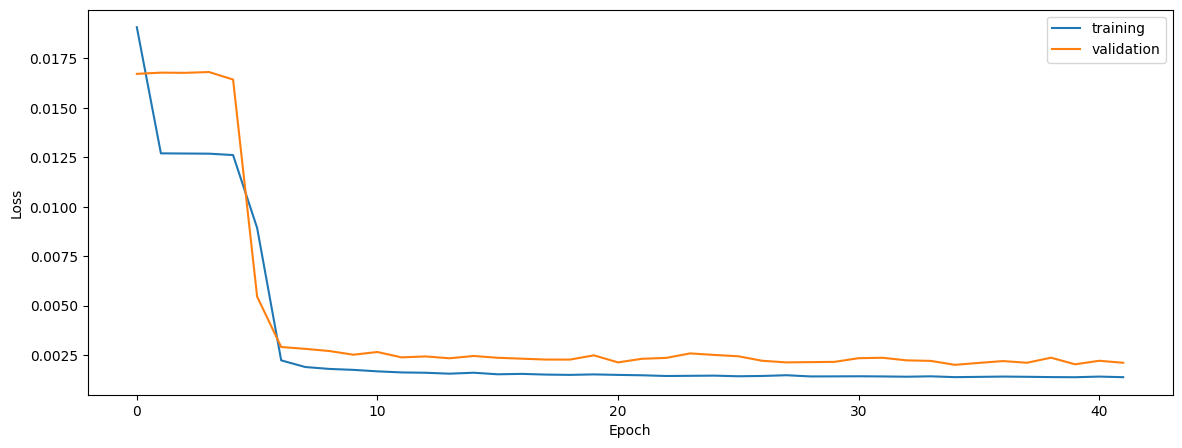

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9436414850393482
0.939212359254862
0.9171869084750819


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9436414850393482
0.939212359254862
0.9171869084750819


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9488048042462545
0.9421838022262131
0.9304098474457052


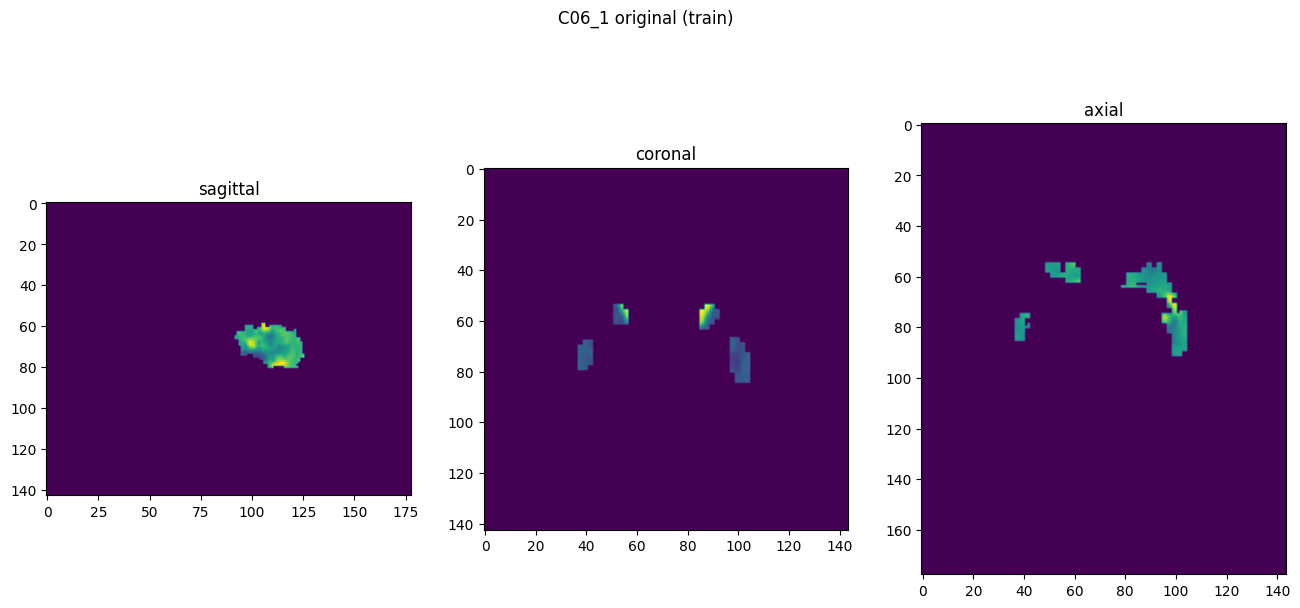

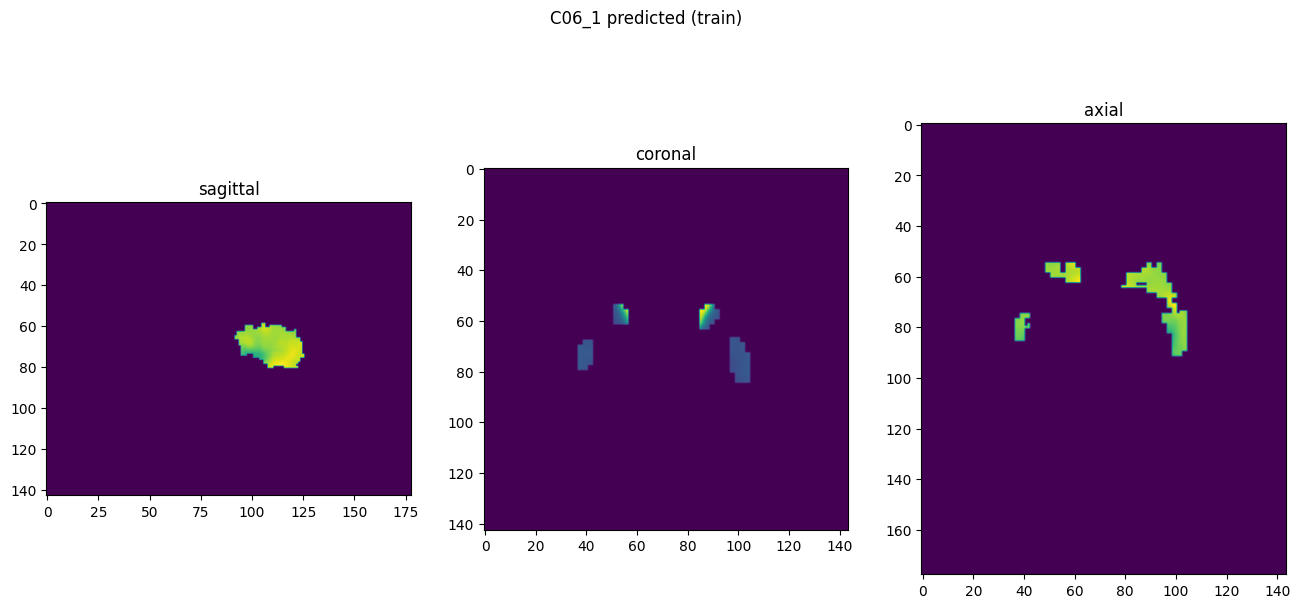

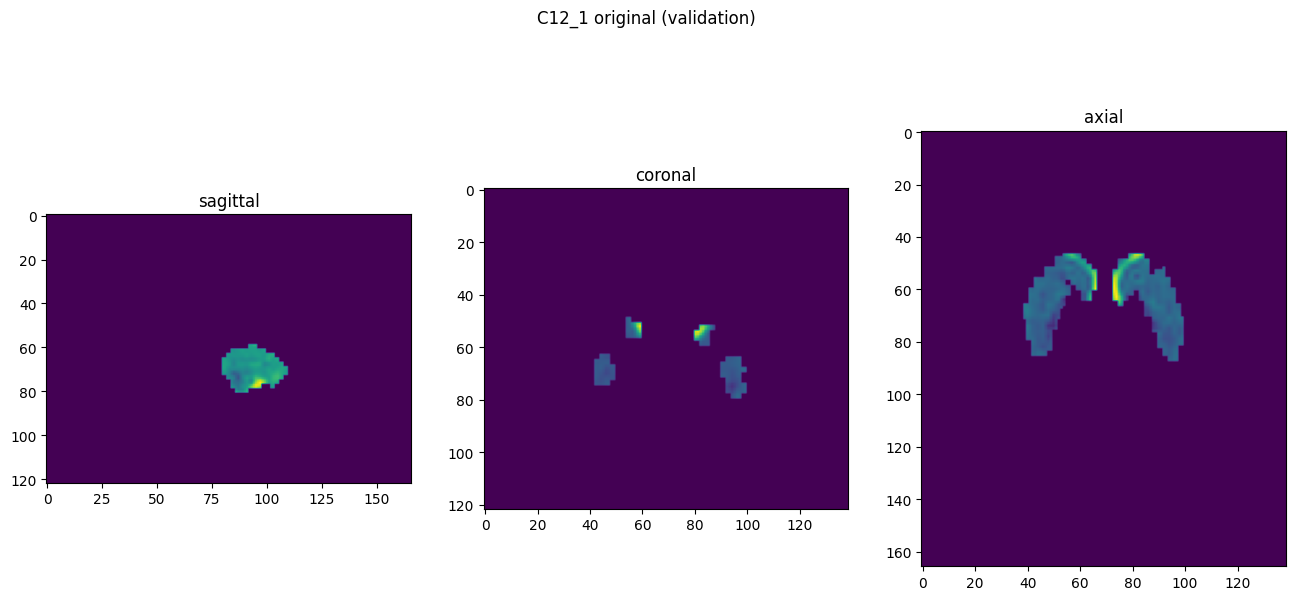

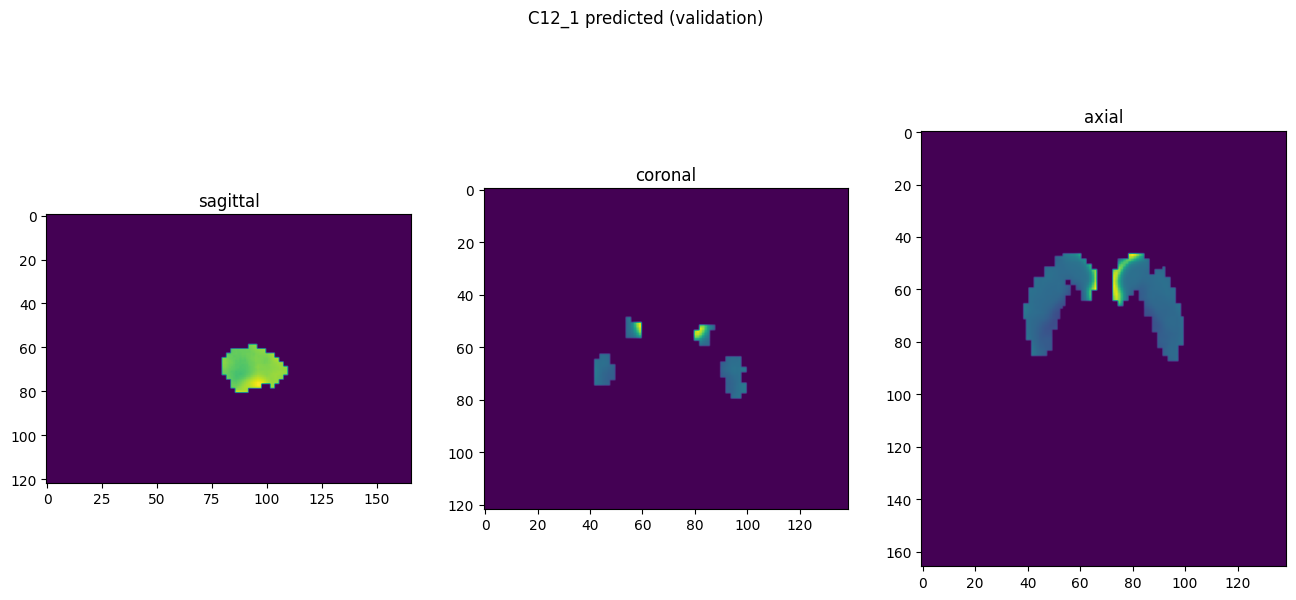

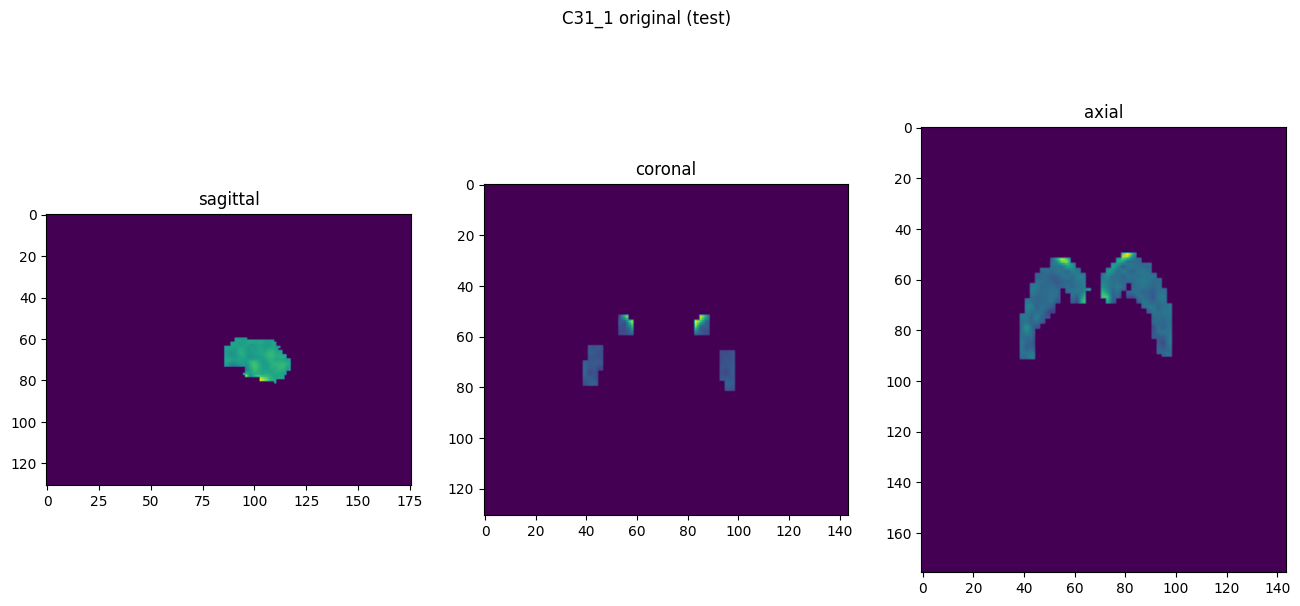

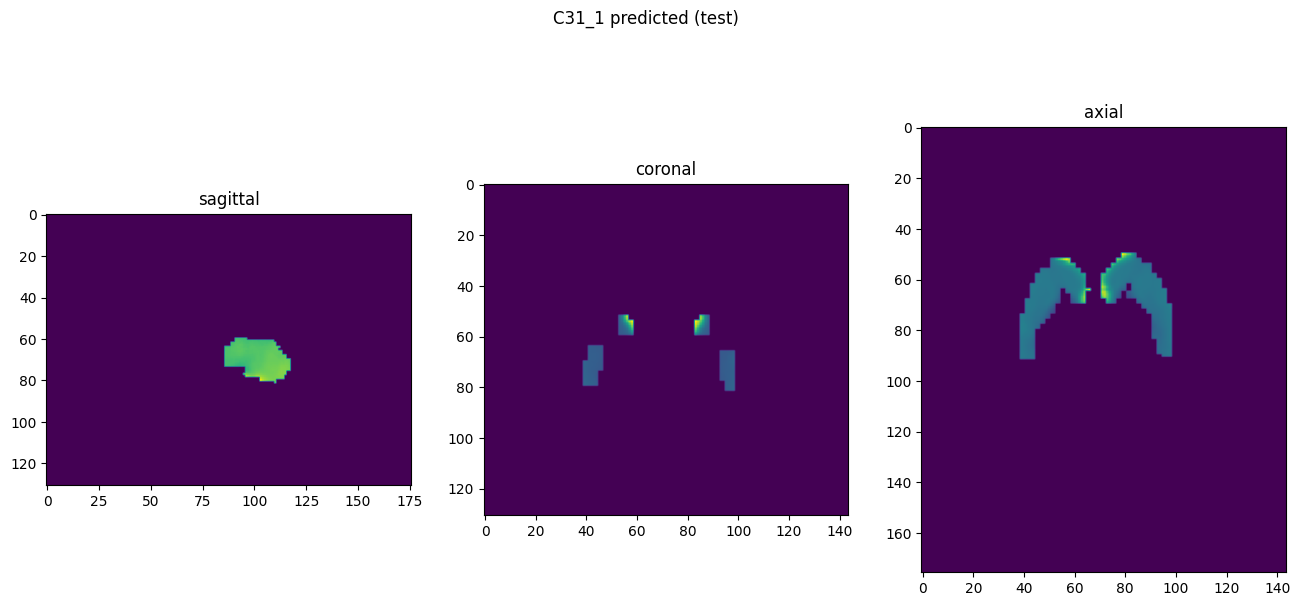

In [10]:
showResults(model, gen, threshold=None, background=False)